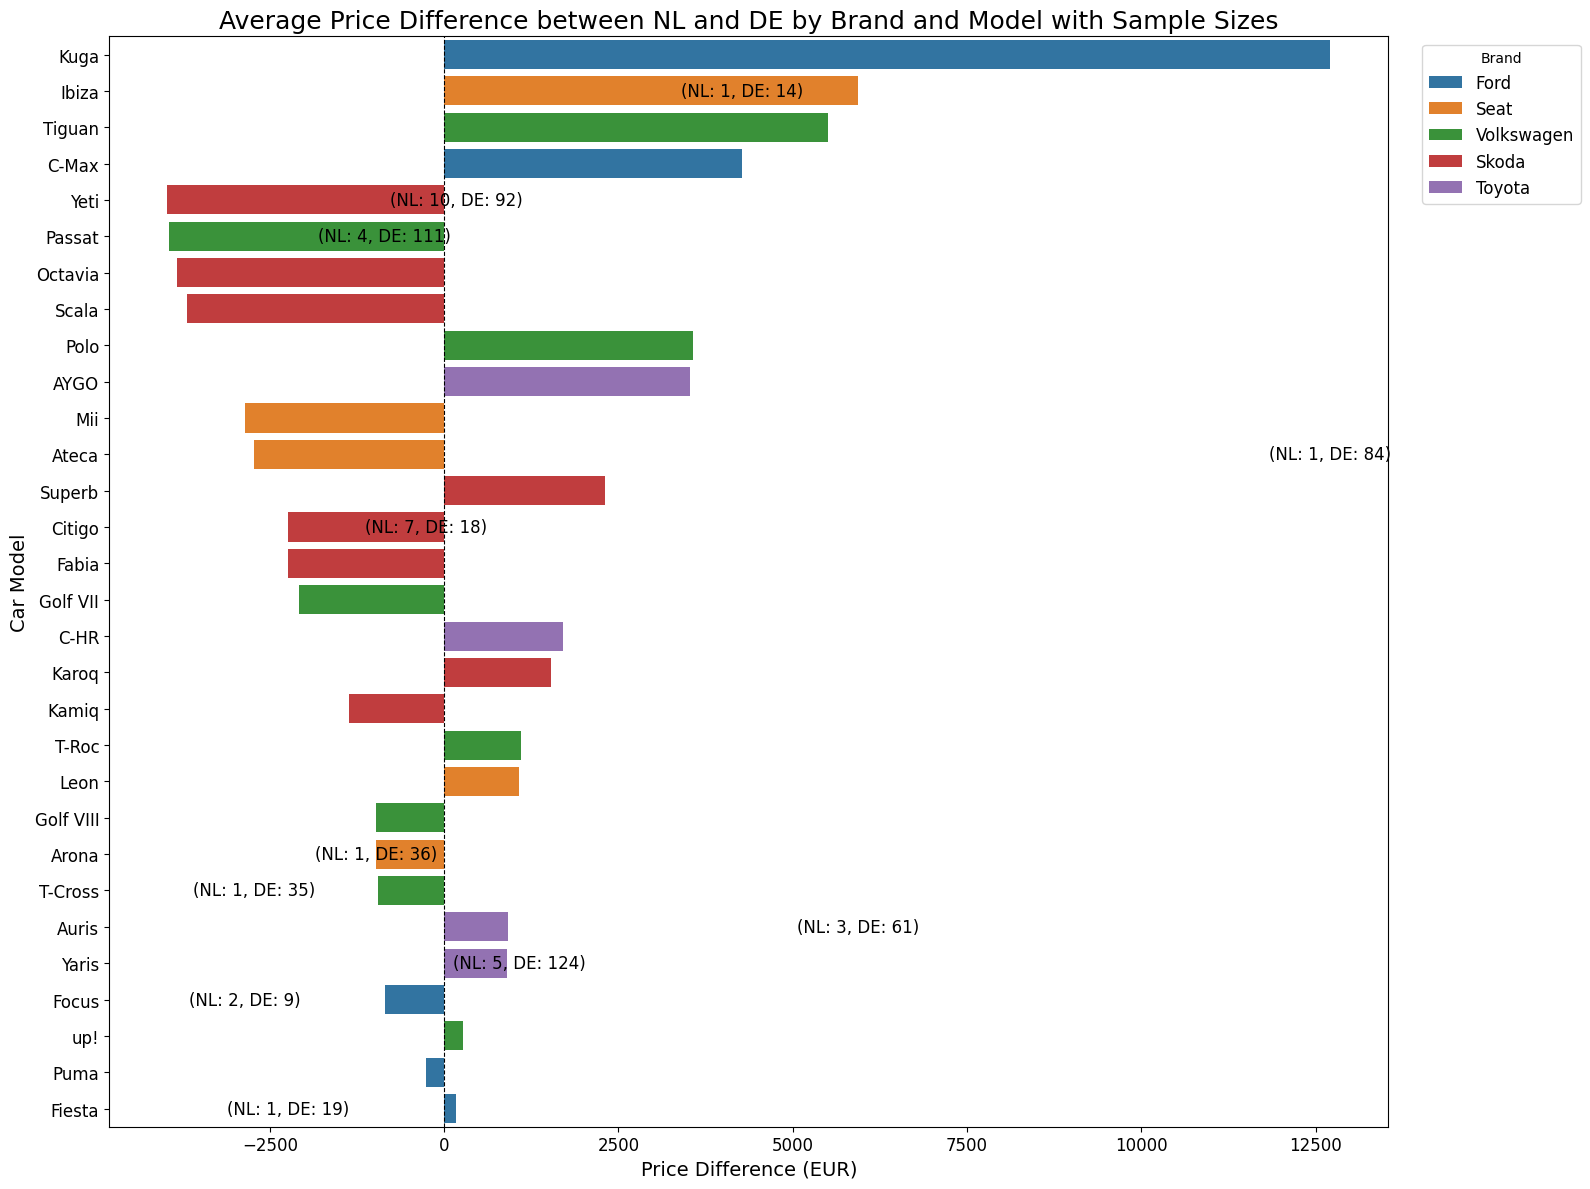

,manufacturer,model,avg_price_DE,avg_price_NL,count_DE,count_NL,price_difference,abs_difference
1,Ford,C-Max,13275.714286,17550.000000,14.0,1.0,4274.285714,4274.285714
4,Ford,Fiesta,12426.739130,12600.000000,92.0,10.0,173.260870,173.260870
5,Ford,Focus,16977.117117,16125.000000,111.0,4.0,-852.117117,852.117117
11,Ford,Kuga,18037.380952,30750.000000,84.0,1.0,12712.619048,12712.619048
13,Ford,Puma,21827.222222,21564.285714,18.0,7.0,-262.936508,262.936508
22,Seat,Arona,16729.444444,15750.000000,36.0,1.0,-979.444444,979.444444
23,Seat,Ateca,21670.857143,18950.000000,35.0,1.0,-2720.857143,2720.857143
24,Seat,Ibiza,12607.540984,18550.000000,61.0,3.0,5942.459016,5942.459016
25,Seat,Leon,18132.822581,19210.000000,124.0,5.0,1077.177419,1077.177419
26,Seat,Mii,9113.333333,6250.000000,9.0,2.0,-2863.333333,2863.333333


In [6]:
# Step 1: Import Required Libraries
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

# Step 2: Load Data
def load_data(country_code):
    file_path = f"../data/{country_code}.json"
    with open(file_path, "r") as file:
        data = [json.loads(line) for line in file]
    return data

nl_data = load_data("NL")
de_data = load_data("DE")

# Step 3: Preprocess Data
def preprocess_data(data, country_code):
    # Converting the data to a DataFrame
    df = pd.DataFrame(data)
    
    # Adding a column to convert price to major units
    df["price_major_units"] = df.apply(lambda x: x["offerPrice"]["amountMinorUnits"] / x["offerPrice"]["conversionMajor"], axis=1)
    
    # Adding the country code as a column for ease of operation
    df["country_code"] = country_code
    
    return df

nl_df = preprocess_data(nl_data, "NL")
de_df = preprocess_data(de_data, "DE")

# Combine both datasets
combined_df = pd.concat([nl_df, de_df], ignore_index=True)

# Step 4: Analyze Price Differences
def analyze_price_difference(df):
    # Filter for brands of interest
    brands_of_interest = ['Skoda', 'Volkswagen', 'Ford', 'Toyota', 'Seat']
    df_filtered = df[df['manufacturer'].isin(brands_of_interest)]
    
    # Group by brand, model, and country, then calculate the mean price and sample size
    grouped = df_filtered.groupby(["manufacturer", "model", "country_code"]).agg(
        avg_price=("price_major_units", "mean"),
        count=("id", "size")
    ).reset_index()
    
    # Pivot the DataFrame to get separate columns for each country
    pivot_df = grouped.pivot_table(index=["manufacturer", "model"], columns="country_code", values=["avg_price", "count"]).reset_index()

    # Flatten the MultiIndex columns
    pivot_df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in pivot_df.columns.values]

    # Filter out the entries that don't have prices for both countries
    pivot_df = pivot_df.dropna()

    # Calculate the price difference
    pivot_df["price_difference"] = pivot_df["avg_price_NL"] - pivot_df["avg_price_DE"]
    
    return pivot_df

price_difference_df = analyze_price_difference(combined_df)

# Step 5: Enhanced Visualization with Sample Sizes
def visualize_price_differences(df):
    # Sort by absolute value of price difference for better visualization
    df["abs_difference"] = df["price_difference"].abs()
    sorted_df = df.sort_values(by="abs_difference", ascending=False)
    
    plt.figure(figsize=(16, 12))
    ax = sns.barplot(
        x="price_difference",
        y="model",
        hue="manufacturer",
        data=sorted_df,
        dodge=False,
        palette="tab10"
    )
    plt.title("Average Price Difference between NL and DE by Brand and Model with Sample Sizes", fontsize=18)
    plt.xlabel("Price Difference (EUR)", fontsize=14)
    plt.ylabel("Car Model", fontsize=14)
    plt.axvline(x=0, color='black', linewidth=0.8, linestyle='--')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Brand', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)
    
    # Annotate the bars with sample sizes
    for index, row in sorted_df.iterrows():
        avg_price_nl = row["avg_price_NL"]
        avg_price_de = row["avg_price_DE"]
        count_nl = row["count_NL"]
        count_de = row["count_DE"]
        
        ax.annotate(f'(NL: {count_nl:.0f}, DE: {count_de:.0f})', 
                    xy=(row["price_difference"], index), 
                    ha='center', va='center', 
                    fontsize=12, color='black')
    
    plt.tight_layout()
    plt.show()

visualize_price_differences(price_difference_df)

# Displaying the final DataFrame
price_difference_df


In [19]:
# Step 1: Import necessary libraries
import pandas as pd

# Assuming `combined_df` is already available and contains the combined data for both countries.

# Function to calculate price differences and weighted averages by year
def calculate_price_differences(df):
    # Filter out the necessary columns
    df_filtered = df[['manufacturer', 'model', 'firstRegistrationYear', 'country_code', 'price_major_units']]
    
    # Group by brand, model, year, and country to get average price and count
    grouped = df_filtered.groupby(['manufacturer', 'model', 'firstRegistrationYear', 'country_code']).agg(
        avg_price=('price_major_units', 'mean'),
        count=('price_major_units', 'size')
    ).reset_index()
    
    # Pivot the table to get separate columns for NL and DE prices and counts
    pivot_df = grouped.pivot_table(index=['manufacturer', 'model', 'firstRegistrationYear'], columns='country_code', values=['avg_price', 'count']).reset_index()

    # Flatten the MultiIndex columns
    pivot_df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in pivot_df.columns.values]
    
    # Filter out the rows that have missing values for either NL or DE
    pivot_df = pivot_df.dropna()
    
    # Calculate the price difference and total count for weight calculation
    pivot_df['price_difference'] = pivot_df['avg_price_NL'] - pivot_df['avg_price_DE']
    pivot_df['total_count'] = pivot_df['count_NL'] + pivot_df['count_DE']
    
    # Group by year and calculate the weighted average price difference
    year_grouped = pivot_df.groupby('firstRegistrationYear').apply(
        lambda x: pd.Series({
            'weighted_avg_price_diff': (x['price_difference'] * x['total_count']).sum() / x['total_count'].sum(),
            'total_count': x['total_count'].sum(),
            'avg_price_NL': (x['avg_price_NL'] * x['total_count']).sum() / x['total_count'].sum(),
            'avg_price_DE': (x['avg_price_DE'] * x['total_count']).sum() / x['total_count'].sum()
        })
    ).reset_index()

    return year_grouped

# Calculate the price differences and average prices
price_diff_year_df = calculate_price_differences(combined_df)

# Display the final DataFrame
price_diff_year_df

/var/folders/3c/v2x71nrj0yd7c2lpjcbt5dp00000gn/T/ipykernel_54718/3062053446.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  year_grouped = pivot_df.groupby('firstRegistrationYear').apply(


,firstRegistrationYear,weighted_avg_price_diff,total_count,avg_price_NL,avg_price_DE
0,2015,-887.221490,130.0,11489.743590,12376.965079
1,2016,52.842300,250.0,13968.400000,13915.557700
2,2017,1174.906009,301.0,18678.073090,17503.167081
3,2018,409.201233,437.0,17150.533944,16741.332710
4,2019,374.432884,412.0,19985.012136,19610.579252
5,2020,1378.800243,248.0,22689.852151,21311.051907
6,2021,1104.519169,118.0,21667.231638,20562.712470
7,2022,2199.716117,26.0,24368.589744,22168.873626
8,2023,2990.000000,4.0,20150.000000,17160.000000
